In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/DL/project

/content/drive/MyDrive/DL/project


In [ ]:
!pip install transformers
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests
import math
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from pathlib import Path
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_dir = Path("/content/drive/MyDrive/DL/project/lung_colon_image_set/colon_image_sets/")

In [ ]:
ds = ImageFolder(data_dir)

In [ ]:
indices = torch.randperm(len(ds)).tolist()
n = len(indices)
n_test = math.floor(n * .15)
n_val = n_test + math.floor(n * .15)
val_ds = torch.utils.data.Subset(ds, indices[0:n_test])
test_ds = torch.utils.data.Subset(ds, indices[n_test:n_val])
train_ds = torch.utils.data.Subset(ds, indices[n_val:n])

In [ ]:
label2id = {}
id2label = {}
for i, class_name in enumerate(ds.classes):
  label2id[class_name] = str(i)
  id2label[str(i)] = class_name

In [ ]:
class ImageClassificationCollator:
   def __init__(self, feature_extractor): 
      self.feature_extractor = feature_extractor
   def __call__(self, batch):  
      encodings = self.feature_extractor([x[0] for x in batch],
      return_tensors='pt')   
      encodings['labels'] = torch.tensor([x[1] for x in batch],    
      dtype=torch.long)
      return encodings

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-384')
collator = ImageClassificationCollator(feature_extractor)

train_loader = DataLoader(train_ds, batch_size=32, 
   collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collator, 
   num_workers=2)

model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch32-384',
        ignore_mismatched_sizes=True,
         num_labels=len(label2id),
         label2id=label2id,
         id2label=id2label)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-384 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tl = []
vl = []

In [ ]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = BinaryAccuracy()
        self.train_acc = BinaryAccuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss, prog_bar=True)
        acc1 = self.train_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"train_acc", acc1, prog_bar=True)
        tl.append(outputs.loss.item())
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss, prog_bar=True)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        vl.append(outputs.loss.item())
        return outputs.loss

    def training_epoch_end(self, outputs) -> None:
        print("Epoch train loss:", outputs[len(outputs) - 1])

    def validation_epoch_end(self, outputs) -> None:
        print("Epoch validation loss:", outputs[len(outputs) - 1])

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr,weight_decay=0.0025)

In [ ]:
pl.seed_everything(1000)
classifier = Classifier(model, lr=2e-5)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content/trainmebby',
    filename='ViT-{epoch:02d}-{val_loss:.2f}',
)
trainer = pl.Trainer(callbacks=[checkpoint_callback],accelerator='gpu', devices=1, precision=16, max_epochs=3)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_lite.utilities.seed:Global seed set to 1000
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | ViTForImageClassification | 87.5 M
1 | val_acc   | BinaryAccuracy            | 0     
2 | train_acc | BinaryAccuracy            | 0     
--------------------------------------------------------
87.5 M    Trainable params
0         Non-trainable params
87.5 M    Total 

Sanity Checking: 0it [00:00, ?it/s]

Epoch validation loss: tensor(0.6284, device='cuda:0')


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch validation loss: tensor(0.0022, device='cuda:0')
Epoch train loss: {'loss': tensor(0.0028, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch validation loss: tensor(0.0012, device='cuda:0')
Epoch train loss: {'loss': tensor(0.1230, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch validation loss: tensor(0.0007, device='cuda:0')
Epoch train loss: {'loss': tensor(0.0011, device='cuda:0')}


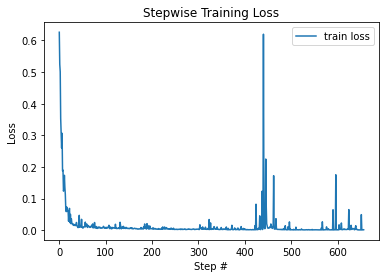

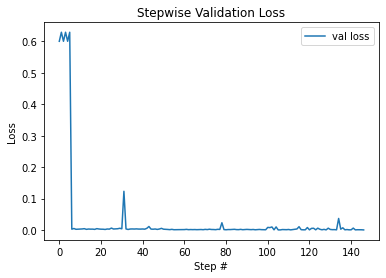

In [ ]:
plt.plot([i for i in tl], label="train loss")
plt.legend()
plt.title("Stepwise Training Loss")
plt.xlabel("Step #")
plt.ylabel("Loss")
plt.show()
plt.plot([i for i in vl], label="val loss")
plt.legend()
plt.title("Stepwise Validation Loss")
plt.xlabel("Step #")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.save(model, '/content/drive/MyDrive/DL/project/model.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/DL/project/model.pt')

In [ ]:
img_dir = [(ds.imgs[i][0]) for i in indices[n_test:n_val]]
true_label = torch.FloatTensor([(ds.imgs[i][1]) for i in indices[n_test:n_val]])

In [ ]:
pred_label = []
pred_label = torch.FloatTensor(pred_label)
for i in img_dir:
   im=Image.open(i)
   encoding = feature_extractor(images=im, return_tensors="pt")
   encoding.keys()
   pixel_values = encoding['pixel_values']
   with torch.no_grad():
    outputs = model(pixel_values)
   result = outputs.logits.softmax(1).argmax(1)
   pred_label = torch.cat((pred_label, result), dim = 0)

In [ ]:
metric_accuracy = BinaryAccuracy()
metric_accuracy(pred_label, true_label)

tensor(0.9987)

In [ ]:
metric_f1 = BinaryF1Score()
metric_f1(pred_label, true_label)

tensor(0.9987)